<a href="https://colab.research.google.com/github/ajipermadi15/Allure-AI-Data-Science-Evaluation-Exercise/blob/main/Create_a_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1: Create a Recommendation System

##Import Library and 
Online E-commerce websites like Amazon, Filpkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchased and rated items to similar items, then combines those similar items into a recommendation list for the user. In this project we are going to build recommendation model for the electronics products of Amazon.

The dataset here is taken from the below website.

Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has several datasets. For this case study, we are using the Electronics dataset.

Attribute Information:

● userId : Every user identified with a unique id (First Column)

● productId : Every product identified with a unique id(Second Column)

● Rating : Rating of the corresponding product by the corresponding user(Third Column)

● timestamp : Time of the rating ( Fourth Column)

In [2]:
#@title Import Library and Data
#!pip install pandas==0.21
#!pip install kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import zipfile
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
import pickle

#Upload kaggle.json for credential
files.upload()

#Make folder and access
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Downloading dataset from kaggle
!kaggle datasets download -d saurav9786/amazon-product-reviews
!ls

#Extracting Zip
zip_ref = zipfile.ZipFile('amazon-product-reviews.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

#Read CSV file
elecs_dataset = pd.read_csv('/content/files/ratings_Electronics (1).csv', names=['UserId', 'ProductId','Rating','Timestamp'])

Saving kaggle.json to kaggle.json
 90% 99.0M/109M [00:01<00:00, 65.9MB/s]
100% 109M/109M [00:01<00:00, 75.6MB/s] 
amazon-product-reviews.zip  kaggle.json  sample_data


In [3]:
#@title Show the First Five Data
elecs_dataset.head()

,UserId,ProductId,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


##Analyze the Dataset

In [4]:
#@title Check Null Values in Dataset
for column in elecs_dataset.columns:
  print('There is {} null value(s) in column {}'.format(elecs_dataset[column].isna().sum(), column))

There is 0 null value(s) in column UserId
There is 0 null value(s) in column ProductId
There is 0 null value(s) in column Rating
There is 0 null value(s) in column Timestamp


In [5]:
#@title Total Unique Users and Products
print('There are {} unique users'.format(len(np.unique(elecs_dataset.UserId))))
print('There are {} unique products'.format(len(np.unique(elecs_dataset.ProductId))))

There are 4201696 unique users
There are 476002 unique products


In [6]:
#@title Describe the Rating Column
elecs_dataset['Rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

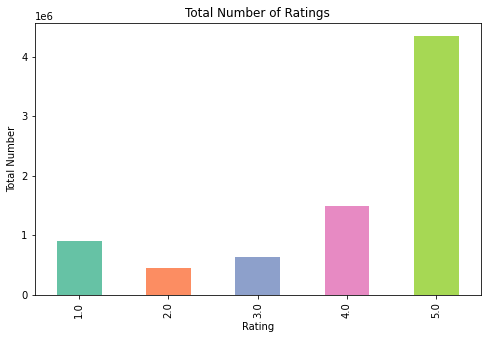

In [7]:
#@title Show Rating Distribution with Bar Plot
elecs_dataset.groupby('Rating').count()['ProductId'].plot(kind = 'bar', 
                                                          color = sns.color_palette("Set2", 5),
                                                          xlabel = 'Rating',
                                                          ylabel = 'Total Number',
                                                          title = 'Total Number of Ratings',
                                                          figsize = (8,5))

In [8]:
#@title Rating Given by The User
elecs_dataset.groupby(['UserId']).count()['Rating'].sort_values(ascending = False).head()

UserId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64

In [9]:
#@title Average Rating and Number of Ratings for Each Product
avr_rating = elecs_dataset.groupby('ProductId').mean()['Rating'].sort_values(ascending = False)
nmb_rating = elecs_dataset.groupby('ProductId').count()['Rating'].sort_values(ascending = False)

avr_dict = {'Product Id' : avr_rating.index,
     'Average Rating' : avr_rating.values}
nmb_dict = {'Product Id' : nmb_rating.index,
     'Number of Ratings' : nmb_rating.values}

avr_df = pd.DataFrame(avr_dict)
nmb_df = pd.DataFrame(nmb_dict)

pd.merge(avr_df, nmb_df, on='Product Id', how='inner').sort_values(by=['Number of Ratings', 'Average Rating'], ascending = [False, False]).head()

,Product Id,Average Rating,Number of Ratings
187021,B0074BW614,4.491504,18244
295153,B00DR0PDNE,3.931020,16454
192457,B007WTAJTO,4.424005,14172
140365,B0019EHU8G,4.754497,12285
208525,B006GWO5WK,4.314657,12226


##Split Data Training and Data Test

In [10]:
#@title Drop the Timestamp Column
elecs_dataset.drop(columns = 'Timestamp', inplace=True)

In [11]:
#@title Get Subset of The Data
dataset = elecs_dataset.iloc[:1000000,0:]

#Filtering Data
#dataset = dataset.groupby("UserId").filter(lambda x:x['Rating'].count() >=20)
dataset = dataset.groupby("ProductId").filter(lambda x:x['Rating'].count() >=50)

#Get 20000 Dat
dataset = dataset.head(20000)


In [12]:
#@title Split 10% Data as Data Test
data_train, data_test= train_test_split(dataset, test_size=0.1, random_state=1)
print('Shape of Data Train: {}\nShape of Data Test: {}'.format(data_train.shape, data_test.shape))

Shape of Data Train: (18000, 3)
Shape of Data Test: (2000, 3)


##Training Data

In [13]:
#@title Pivot and Create Product-user Matrix
product_user_mat = data_train.pivot(index='ProductId', columns='UserId', values='Rating').fillna(0)
product_user_mat.head()

UserId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A076219533YHEV2LJO988,A07730732C0MK8X9APP6C,A08523431UFFNYIQR59LY,A099626739FNCRNHIKBCG,A1003EYWAQFOUG,A1008Z48LB2QI4,A100LLXMXDZHJZ,A100SER4Z9YAWR,A100WO06OQR8BQ,A10121433FMMZNY18RWZ8,A1013OEQCVS6AR,A1013Q8NLCY56R,A101DJDPGK0Q46,A101N04POEB9CL,A1025SYFKSMERB,A1027EV8A9PV1O,A1028F2JVII4S7,A1028XZRNI0NRP,A102EC3XGCBZ81,A102IUFPXVDRB6,A102L0RVI4LHH3,A102NXMIVU82AK,A102RLOGIBBDMW,A102ZABPUPNYCT,A1038957GWRBP375RU5T,A103MTOZ2Z6FOB,A103XY7DJYZHFN,A104F83PVACKQF,A104VHQ06KFLDT,A1052FQY7XU5FP,A1056BTJ3V0J6T,A1058D8UFZL711,A105GTJB0OQ28O,A105PQAOG3DGP2,...,AZQ9DYG38GVBR,AZQJQBJ75DHMS,AZQOWHUHXMIMS,AZQQVI9RHJYH6,AZQTJ6HUS5L2Q,AZRJH4JFB59VC,AZRPGTU8A7KD5,AZRR55GM4Y9NK,AZS8W54PXQ01W,AZSH7IFNZR62F,AZSKORJRCSQ38,AZSUNAT0BRQDU,AZTAC5WZ4QDRN,AZTC7YC8PKG39,AZTC8ZV20NO1D,AZTJJ7AGB88YZ,AZTPP57BPF0W7,AZTZ61W23JET0,AZUUV3DEO6Z4J,AZV6J8966E8IE,AZV8YD0X0F5Z3,AZV9WA9MNT0FB,AZVL57D2NG3T1,AZVRZHRWM2OVA,AZW8H05DVPSGS,AZWHN4ENMEZLI,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX2RDN9YXZAE,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXCV0SD51HI9,AZXKUK895VGSM,AZXP46IB63PU8,AZXWUZ9PPSOTL,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZP8BC9WE0N8,AZZST8OYL5P4Q
ProductId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0972683275,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1400532620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#@title Decomposing the Matrix

SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(product_user_mat)
decomposed_matrix.shape

(115, 10)

In [15]:
#@title Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(115, 115)

## Saving Model

In [16]:
#@title Save Model to the Drive
pickle.dump([product_user_mat, correlation_matrix],open('model.pkl','wb'))

## Load Model

In [17]:
#@title Load Model
model, corr_mat = pickle.load(open('model.pkl','rb'))

##Test Model

In [61]:
#@title Test Model

prd = input('Input your favorite product ID: ')

model, corr_mat = pickle.load(open('model.pkl','rb'))
product_names = list(model.index)
product_ID = product_names.index(prd)
correlation_product_ID = corr_mat[product_ID]
Recommend = list(model.index[correlation_product_ID > 0.70])
Recommend.remove(prd) 

print('We recommend the following products: ')
for i in range(len(Recommend[0:5])):
    print('{}. {}'.format(i+1, Recommend[i]))

print('We hope you enjoy with our recommendations.')

Input your favorite product ID: B00002CEX9
We recommend the following products: 
1. 9625993428
2. B00000J1UQ
3. B00000JD34
4. B00001OXQ9
5. B00001P4XH
We hope you enjoy with our recommendations.


##Evaluate Model

In [19]:
#@title Build APK and MAPK Function

def apk(actual, predicted, k=5):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=5):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [72]:
#@title Build Predict Function

def predict(prd):
  product_names = list(model.index)
  product_ID = product_names.index(prd)
  correlation_product_ID = corr_mat[product_ID]
  Recommend = list(model.index[correlation_product_ID > 0.70])
  Recommend.remove(prd)
  return Recommend

In [91]:
#@title Evaluate Training with MAPK 
actual = []
predicted = []

for idx in count[count['ProductId'] > 3].index:
  id = data_train.groupby(['UserId','ProductId']).count().loc[idx].index
  predicted.append(predict(id[0]))
  actual_ = []
  for i in range(1,len(id)):
    actual_.append(id[i])
  actual.append(actual_)

mapk(actual, predicted)

0.03333333333333333

The MAPK value obtained is very small, which means the model is less accurate. This could be due to the selection of data subsets that are less evenly distributed. From the total dataset, only 20000 were taken with 18000 as train data. As for the data taken, very few active users (eg: users gave rate more than 10 times). The reason I don't use all the datasets is because the data is too much so it will take a very long time to process and training.
There are several things that can be done to improve the model:
1. Increase the amount of training data
2. Filter by retrieving data containing active users (often giving ratings to products)
3. Make recommendations system in other ways, such as: Collaborative filtering, Popularity Based Recommendation, Hybrid, etc


